In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import skimage

from src.models import InputImage
from src.filters import yen_th, sobel
from skimage.morphology import disk, binary_closing, binary_opening, convex_hull_image

#

# Searching well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Creating mask for well
_____________________________________________________________
# Searching fish properties
_____________________________________________________________
# Removing background
_____________________________________________________________
# Applying Yen-thresholding
_____________________________________________________________
# Stored binary image in object
_____________________________________________________________
# Finding largest object
_____________________________________________________________
NOT FISH!
Isn't eccentric enough: 0.8145685400947659
Refine fish convex hull #1
# Refining convex hull of fish
_____________________________________________________________
# Finding largest object's convex hull
_____________________________________________________________
# Find

Text(0.5, 1.0, 'fish_props.mask.masked')

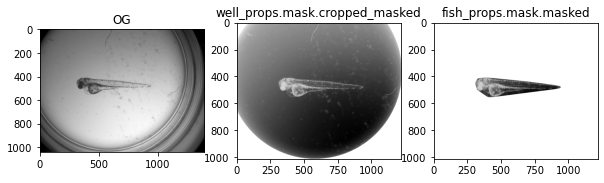

In [74]:
from src.fish.find_fish_props import find_fish_props
from src.well.find_well_props import find_well_props

fishy = InputImage("zf3.jpg")
fishy = find_well_props(fishy)
fishy = find_fish_props(fishy)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
ax = ax.ravel()

ax[0].imshow(fishy.og, "binary")
ax[0].set_title('OG')
ax[1].imshow(fishy.well_props.mask.cropped_masked, "binary")
ax[1].set_title('well_props.mask.cropped_masked')
ax[2].imshow(fishy.fish_props.mask.masked, "binary")
ax[2].set_title('fish_props.mask.masked')


# Finding largest object
_____________________________________________________________


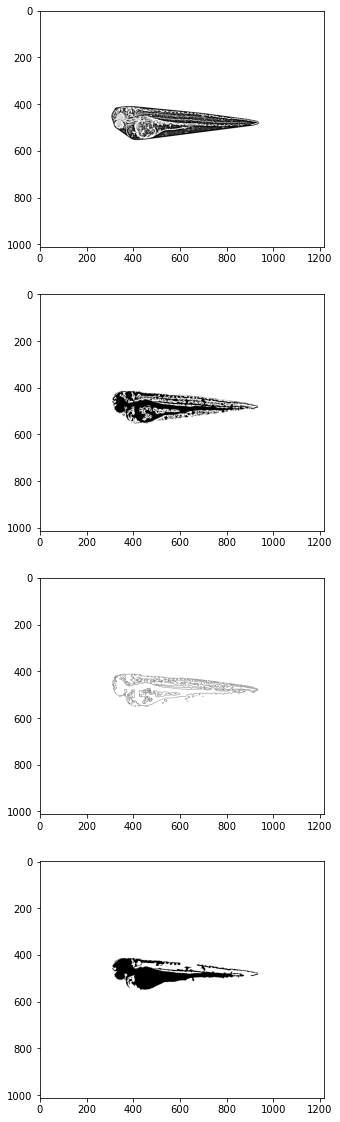

In [94]:
from skimage.measure import label
from skimage.feature import canny
from skimage.exposure import equalize_hist
from skimage.morphology import binary_dilation, closing, opening
from scipy import ndimage
from src.utils import keep_largest_object
from skimage.filters.ridges import frangi, meijering
from skimage.filters._unsharp_mask import unsharp_mask

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 20))
ax= ax.ravel()

masked = fishy.fish_props.mask.masked

um = unsharp_mask(masked, amount=30, radius=2)
meij = meijering(masked) * fishy.fish_props.mask.og


well_masked = fishy.well_props.mask.cropped_masked

ax[0].imshow(um, 'binary')
ax[1].imshow(yen_th(equalize_hist(meij)), 'binary')
ax[2].imshow(canny(yen_th(meij)), 'binary')
ax[3].imshow(keep_largest_object((yen_th(meij))), 'binary')